In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../source/")
from softpy.evolutionary import *
from functools import partial
import scipy
from copy import deepcopy, copy
import seaborn as sns

# Symbolic Programming

In [3]:
def eval_tree_symbolic(t: TreeCandidate, value_pairs: dict, funcs, replace=True):
    
    def visit(n: TreeCandidate.NodeCandidate, value_pairs: dict, funcs: dict, replace=True):
        if n.children is None:
            if isinstance(n.function, str) and replace:
                return str(value_pairs[n.function])
            elif isinstance(n.function, str):
                return n.function
            elif np.issubdtype(type(n.function), np.number):
                return str(n.function)
            
        else:
            strings = [visit(c, value_pairs, funcs, replace) for c in n.children]
            if len(n.children) == 2:
                if (n.function == "/") and (replace) and (eval(strings[1]) == 0):
                    return "1"
                elif (n.function == "^") and (replace) and (np.isnan(eval(strings[0] + "**" + strings[1])) or np.iscomplex(eval(strings[0] + "**" + strings[1]))):
                    return "1"
                else:
                    return "(" + strings[0] + " " + funcs[n.function] + " " + strings[1] + ")"
            elif len(n.children) == 1:
                if n.function == "log":
                    return funcs[n.function] + "(np.abs(" + strings[0] + "))"
                else:
                    return funcs[n.function] + "(" + strings[0] + ")"
            
    res = visit(t.root, value_pairs, funcs, replace)
    return res
        

In [11]:
funcs = {
    "+": "+",
    "*": "*",
    "/": "/",
    "-": "-",
    "^": "**",
    "sin": "np.sin",
    "cos": "np.cos",
    "exp": "np.exp",
    "log": "np.log"
}

arities = [2, 2, 2, 1, 2, 1, 1, 1, 1]

def constant_generator(variables=["x"], low=-1.5, upp=1.5):
    r = np.random.rand()
    if r < 0.7:
        return np.random.choice(variables)
    else:
        return np.random.uniform(low, upp)

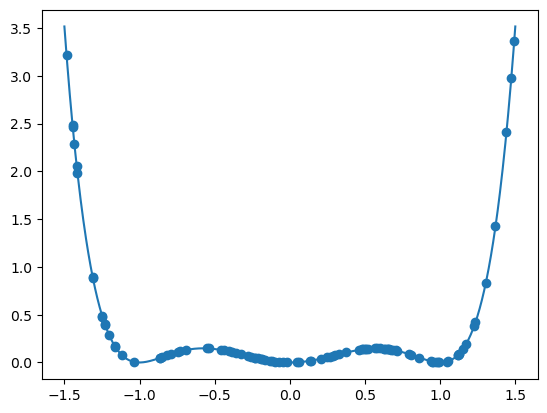

In [12]:
def benchmark_func(x):
    return x**6 - 2*(x**4) + x**2

X = np.random.rand(100)*3 - 1.5
y = benchmark_func(X)

r = np.linspace(-1.5,1.5,1000)
y_all = benchmark_func(r)

plt.plot(r, y_all)
plt.scatter(X, y)

In [13]:
def fitness(c: TreeCandidate, X, y, funcs):
    y_pred = ([eval_tree_symbolic(c, {"x": x}, funcs) for x in X])
    y_pred = np.array([eval(t) for t in y_pred], dtype=y.dtype)
    fit = np.sum((y_pred - y)**2)
    #print(eval_tree_symbolic(c, {"x": "x"}, funcs, replace=False), " ", fit)
    return -fit

In [14]:
genalgo_symbolic = GeneticAlgorithm(100,
                                    TreeCandidate,
                                    partial(tournament_selection, tournament_size=7),
                                    partial(fitness, X=X, y=y, funcs=funcs),
                                    elitism=False,
                                    **{"function_set": list(funcs.keys()),
                                       "arities": arities,
                                       "max_depth": 4,
                                       "max_absolute_depth": 4,
                                       "constant_generator": partial(constant_generator, ["x"], -1, 1),
                                       "stop_early_prob": 0.25})

In [15]:
iters = 100

genalgo_symbolic.fit(iters, keep_history=True)
history_f = genalgo_symbolic.fitness_h
history_b = genalgo_symbolic.best_h

<string>:1: RuntimeWarning: invalid value encountered in scalar power


In [16]:
eval_tree_symbolic(history_b[-1], {"x": "x"}, funcs, replace=False)

'((x * (0.4330759378153508 * x)) * (x * x))'

(0.0, 100.0)

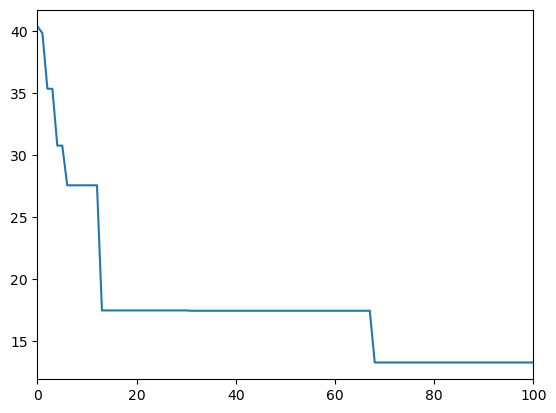

In [17]:
plt.plot(-history_f)
plt.xlim(0,iters)

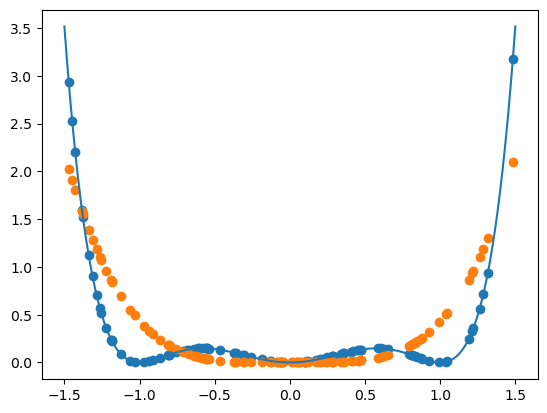

In [18]:
X = np.random.rand(100)*3 - 1.5
y = benchmark_func(X)

r = np.linspace(-1.5,1.5,1000)
y_all = benchmark_func(r)

y_pred = np.array([eval(eval_tree_symbolic(history_b[-1], {"x": x}, funcs)) for x in X])

plt.plot(r, y_all)
plt.scatter(X, y)
plt.scatter(X, y_pred)

# Artificial Ant

In [11]:
class ConditionalPlan:
    def __init__(self, p_then, p_else):
        self.p_then = p_then
        self.p_else = p_else
        
    def __str__(self):
        s_t = [str(a) for a in self.p_then]
        s_e = [str(a) for a in self.p_else]
        print("if food-ahead then " + str(s_t) + " else " + str(s_e))

In [12]:
def eval_tree_ant(t: TreeCandidate):
    
    def visit(n: TreeCandidate.NodeCandidate, plan):
        if n.children is None:
            return n.function
        else:
            if n.function in ["progn3", "progn2"]:
                for c in n.children:
                    plan.append(visit(c, plan))
            elif n.function == "if":
                p_t = visit(n.children[0],[])
                p_t = p_t if isinstance(p_t, list) else [p_t]
                
                p_e = visit(n.children[1],[])
                p_e = p_e if isinstance(p_e, list) else [p_e]
                plan.append(ConditionalPlan(p_t, p_e))
            return plan
            
            
    res = visit(t.root, [])
    return res
        

In [13]:
funcs = ["progn3", "progn2", "if"]

arities = [3,2,2]

def constant_generator():
    r = np.random.rand()
    if r < 0.5:
        return "move"
    elif 0.5 <= r < 0.75:
        return "right"
    else:
        return "left"

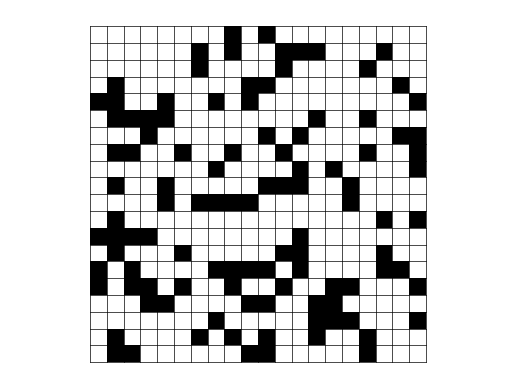

In [14]:
n = 20

grid = np.random.choice([0,1], size=(n,n), p=(0.75,0.25))


def plot_grid(grid, ax=None):
    ax.axis('equal')
    ax.axis('off')
    for i in range(grid.shape[0]+1):
        # horizontal and vertical background lines
        ax.plot([i,i], [0,grid.shape[0]], linewidth=0.5, color='black')
        ax.plot([0,grid.shape[0]], [i,i], linewidth=0.5, color='black')

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i,j] == 1:
                plt.fill([j, j+1, j+1, j],
                        grid.shape[1] - np.array([i,i,i+1,i+1]),
                        'k')

fig, ax = plt.subplots()
plot_grid(grid, ax)

In [15]:
grid

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 1,

In [16]:
class Position:
    def __init__(self, n, m):
        self.pos = [0,0]
        self.toward = "right"
        self.n = n
        self.m = m
        self.path = [(self.pos[0], self.pos[1], self.toward)]
        
    def rotate(self, where="right"):
        r_r = {"up": "right",
               "right": "down",
               "down": "left",
               "left": "up"}
        r_l = {"up": "left",
               "left": "down",
               "down": "right",
               "right": "up"}
        
        self.toward = r_r[self.toward] if where == "right" else r_l[self.toward]
        self.path.append((self.pos[0], self.pos[1], self.toward))
    
    def move(self):
        if self.toward == "up":
            self.pos[0] = (self.pos[0] - 1)%self.n
        elif self.toward == "down":
            self.pos[0] = (self.pos[0] + 1)%self.n
        elif self.toward == "right":
            self.pos[1] = (self.pos[1] + 1)%self.m
        elif self.toward == "left":
            self.pos[1] = (self.pos[1] - 1)%self.m
        self.path.append((self.pos[0], self.pos[1], self.toward))
            
    def check(self):
        if self.toward == "up":
            return ((self.pos[0] + 1)%self.n, self.pos[1])
        elif self.toward == "down":
            return ((self.pos[0] - 1)%self.n, self.pos[1])
        elif self.toward == "right":
            return (self.pos[0], (self.pos[1] + 1)%self.m)
        elif self.toward == "left":
            return (self.pos[0], (self.pos[1] - 1)%self.m)
        
        
def execute_plan(plan, pos: Position, points, grid, time, max_time):
        if grid[pos.pos[0],pos.pos[1]] == 1:
            points += 1
            grid[pos.pos[0],pos.pos[1]] = 0
            
                    
        for act in plan:
            if isinstance(act, str):
                if act in ["right","left"]:
                    pos.rotate(where=act)
                    time += 1
                    if time > max_time:
                        return (time, points, grid)
            
                elif act == "move":
                    pos.move()
                    if grid[pos.pos[0],pos.pos[1]] == 1:
                        points += 1
                        grid[pos.pos[0],pos.pos[1]] = 0
                    time += 1
                    if time > max_time:
                        return (time, points, grid)
            elif isinstance(act, ConditionalPlan):
                next_pos = pos.check()
                if grid[next_pos[0],next_pos[1]] == 1:
                    res = execute_plan(act.p_then, pos, points, grid, time, max_time)
                    time = res[0]
                    points = res[1]
                    grid = res[2]
                else:
                    res = execute_plan(act.p_else, pos, points, grid, time, max_time)
                    time = res[0]
                    points = res[1]
                    grid = res[2]
        return time, points, grid

def fitness(c: TreeCandidate, grid, max_time, return_grid=False):
        
    pos = Position(grid.shape[0], grid.shape[1])
    time = 0
    points = 0
    my_grid = copy(grid)
    
    while time < max_time:
        plan = eval_tree_ant(c)
        res = execute_plan(plan, pos, points, my_grid, time, max_time)
        time = res[0]
        points = res[1]
        my_grid = res[2]
     
    if return_grid:
        return points, my_grid, pos.path
    else:
        return points

In [21]:
max_time = 10

genalgo_ant = GeneticAlgorithm(10,
                               TreeCandidate,
                               partial(tournament_selection, tournament_size=7),
                               partial(fitness, grid=grid, max_time=max_time),
                               elitism=False,
                               **{"function_set": funcs,
                                  "arities": arities,
                                  "max_depth": 3,
                                  "max_absolute_depth": 5,
                                  "constant_generator": constant_generator,
                                  "stop_early_prob": 0.2})

In [22]:
iters = 10

genalgo_ant.fit(iters, keep_history=True, show_iters=True)
history_f = genalgo_ant.fitness_h
history_b = genalgo_ant.best_h

0
1


KeyboardInterrupt: 

In [ ]:
print(history_f)
plt.plot(history_f)
plt.xlim(0,iters)
plt.ylim(0, np.sum(grid))

In [ ]:
def pretty_print(plan, indent):
    for act in plan:
        if act in ["move", "left", "right", "down", "up"]:
            print("\t"*indent + act)
        elif isinstance(act, ConditionalPlan):
            print("\t"*indent + "if food-ahead then")
            pretty_print(act.p_then, indent+1)
            print("\t"*indent + "else")
            pretty_print(act.p_else, indent+1)

plan = eval_tree_ant(history_b[-1])
pretty_print(plan, 0)

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize = (5,5))
plt.rcParams["animation.html"] = "jshtml"

score, my_grid, path = fitness(history_b[-1], grid, max_time, return_grid=True)

palette = sns.color_palette("viridis", len(path))

plot_grid(grid, ax)

scat = ax.scatter([],[]) 

grid_size = my_grid.shape[0]

def animate_path(frame_num):
    arrow = {
        "up" : "^",
        "down": "v",
        "right": ">",
        "left": "<"
    }

    path_x = np.array([grid_size - (p[0] + 0.5) for p in path[:frame_num]])
    path_y = np.array([ (p[1] + 0.5) for p in path[:frame_num]])
    markers = np.array([arrow[p[2]] for p in path[:frame_num]])
    scat.set_offsets(np.vstack([path_y, path_x]).T)
    scat.set_color(palette[:frame_num])
    return scat

anim = FuncAnimation(fig, animate_path, frames=len(path), interval=1000)
plt.close()

In [ ]:
anim